In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats
import cellbayesassay as cba
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
concentrations = {
    'c1': 10e-6,
    'c2': 3e-6,
    'c3': 1e-6,
}
concentrations.update({'LC': min(concentrations.values()) / 1e3})

In [3]:
data = cba.read_data(compound='TI26', assay='TNF', bname='../../resources/cell-based-assays/Tina-email-2023-08-31/')
data

,VC,c1,c2,c3,RI,LC
0,0.917858,0.755247,9.443050,36.121420,1.403177,13.312150
1,1.303890,7.497930,11.304590,1.577535,0.268734,2.062547
2,0.706698,0.442091,12.486180,28.991770,0.276541,1.752594
3,0.771455,0.958683,4.763406,17.613260,0.812029,1.262600
4,0.394515,0.909701,4.902034,1.180168,0.191152,0.593902
5,0.489854,1.303890,3.428685,8.875549,1.594178,51.612920


In [4]:
data_reshaped = cba.read_reshape_data(compound='TI26', assay='TNF', concentrations=concentrations, bname='../../resources/cell-based-assays/Tina-email-2023-08-31/')
data_reshaped

activity          conc  conc_log10
0 c1   0.755247  1.000000e-05   -5.000000
  c2   9.443050  3.000000e-06   -5.522879
  c3  36.121420  1.000000e-06   -6.000000
  LC  13.312150  1.000000e-09   -9.000000
1 c1   7.497930  1.000000e-05   -5.000000
  c2  11.304590  3.000000e-06   -5.522879
  c3   1.577535  1.000000e-06   -6.000000
  LC   2.062547  1.000000e-09   -9.000000
2 c1   0.442091  1.000000e-05   -5.000000
  c2  12.486180  3.000000e-06   -5.522879
  c3  28.991770  1.000000e-06   -6.000000
  LC   1.752594  1.000000e-09   -9.000000
3 c1   0.958683  1.000000e-05   -5.000000
  c2   4.763406  3.000000e-06   -5.522879
  c3  17.613260  1.000000e-06   -6.000000
  LC   1.262600  1.000000e-09   -9.000000
4 c1   0.909701  1.000000e-05   -5.000000
  c2   4.902034  3.000000e-06   -5.522879
  c3   1.180168  1.000000e-06   -6.000000
  LC   0.593902  1.000000e-09   -9.000000
5 c1   1.303890  1.000000e-05   -5.000000
  c2   3.428685  3.000000e-06   -5.522879
  c3   8.875549  1.000000e-06   -6.000000
  LC  51.612920  1.000000e-09   -9.000000

## Spearman correlation: conc vs activity

In [5]:
spearmanr(data_reshaped.drop('conc', axis=1).drop('LC', axis=0, level=1))

SignificanceResult(statistic=-0.6295115802917071, pvalue=0.005119517643890959)

EC_50_mu: originally -5.5, TI26 TNFα

y_0_alpha: originally 20, TI26 TNFα

| Data var. | Interpretation |
|--|--|
| $x$ | drug eff. conc. |
| $Y$ | activity (bioassay) |

\begin{eqnarray}
\mu &=& \mathrm{E}[Y | x] \\
Y &\sim& \mathcal{N}(\mu, \sigma) \qquad \text{linear 1, sigmoid 1} \\ % linear 1, sigmoid 1
Y &\sim& \mathcal{N}(\mu, \sigma \mu) \qquad \text{sigmoid 2} \\ % sigmoid 2
Y &\sim& \Gamma(\alpha \mu, \beta) \qquad \text{sigmoid 3} \\ % sigmoid 3
Y &\sim& \Gamma(\alpha, \frac{\beta}{\mu}) \qquad \text{sigmoid 4} \\ % sigmoid 4
\end{eqnarray}

| Parameter | Interpretation |
|--|--|
| $\mu$ | fitted curve |
| $y_0$ | baseline activity (no drug) |
| $y_1$ | end activity (saturating drug) |
| $\mathrm{EC}_{50}$ | half maximal eff. conc. |
| $k$ | abs. steepness |
| $\mathrm{FC}_y$ | fold change, saturating vs no drug |

\begin{eqnarray}
\mu &=& \left| y_1 + \frac{y_0 - y_1}{(1 + \exp(k * (x - \mathrm{EC}_{50})} \right| \\
\mathrm{FC}_y &=& \frac{y_1}{y_0} \\
\mu &=& \left| y_0 \mathrm{FC}_y + \frac{y_0 (1 - \mathrm{FC}_y)}{(1 + \exp(k * (x - \mathrm{EC}_{50})} \right|
\end{eqnarray}

In [6]:
data_reshaped = cba.read_reshape_data(compound='TI26', assay='TNF', concentrations=concentrations, bname='../../resources/cell-based-assays/Tina-email-2023-08-31/')
x_obs = data_reshaped['conc_log10'].values
y_obs = data_reshaped['activity'].values
example_idata = {name: model(y_obs, x_obs) for name, model in cba.my_models.items()}
model_objects = {name: model(y_obs, x_obs, return_model=True) for name, model in cba.my_models.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


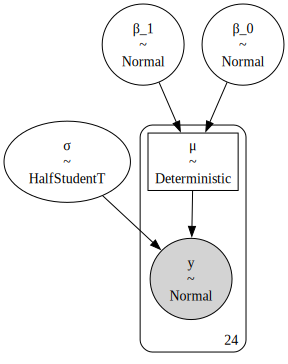

In [7]:
gv = pm.model_to_graphviz(model_objects['linear 1'])
gv.save(filename='linear-1', directory='named-figure/')
gv

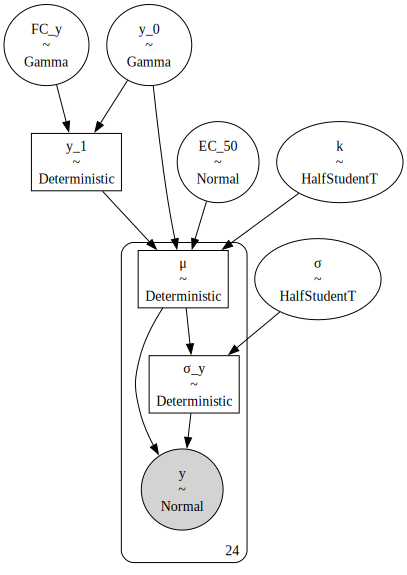

In [8]:
gv = pm.model_to_graphviz(model_objects['sigmoid 2'])
gv.save(filename='sigmoid-2.gv', directory='named-figure/')
gv

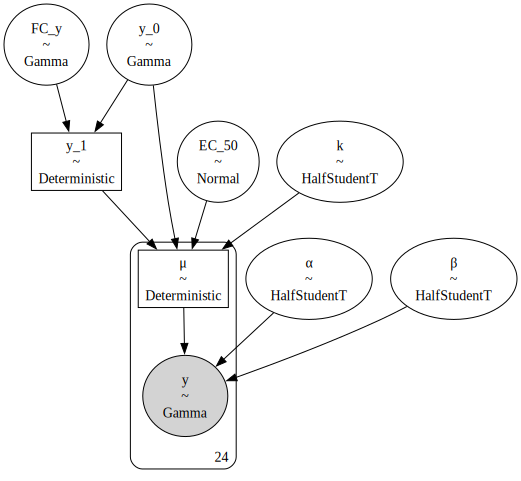

In [9]:
gv = pm.model_to_graphviz(model_objects['sigmoid 4'])
gv.save(filename='sigmoid-4.gv', directory='named-figure/')
gv

In [10]:
model_comparison = az.compare({k: v for k, v in example_idata.items()})
model_comparison

/Users/jonesa7/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
sigmoid 4,0,-77.173898,2.495949,0.000000,9.874592e-01,6.431296,0.000000,False,log
sigmoid 3,1,-78.673107,2.560441,1.499209,0.000000e+00,6.937870,0.916459,False,log
sigmoid 2,2,-87.291906,4.124090,10.118008,1.254077e-02,4.639598,4.826723,True,log
sigmoid 1,3,-97.833005,3.053481,20.659106,0.000000e+00,4.538453,4.813654,False,log
linear 1,4,-98.710133,4.531144,21.536234,2.167155e-13,6.420394,4.452760,True,log


['named-figure/model-comparison.png', 'named-figure/model-comparison.pdf']

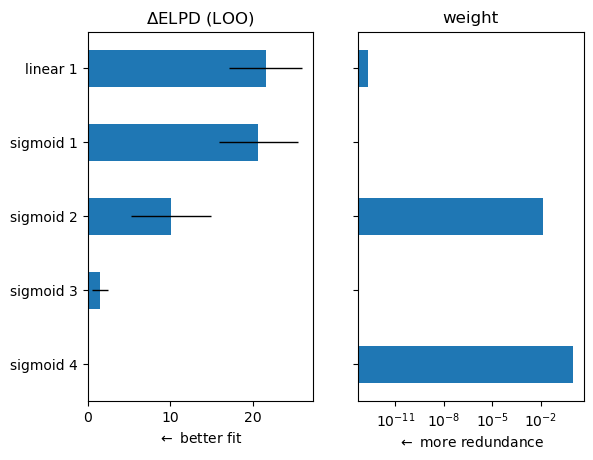

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True)
model_comparison['elpd_diff'].plot(kind='barh', ax=ax[0])
ax[0].errorbar(x='elpd_diff', y='rank', xerr='dse', data=model_comparison, linewidth=0, elinewidth=1, ecolor='k')
model_comparison['weight'].plot(kind='barh', ax=ax[1])
ax[1].set_xscale('log')
ax[0].set_title('$\Delta$ELPD (LOO)')
ax[0].set_xlabel('$\leftarrow$ better fit')
ax[1].set_title('weight')
ax[1].set_xlabel('$\leftarrow$ more redundance')
attila_utils.savefig(fig, 'model-comparison')

In [12]:
ssize = 1000
prior_samples = {m: pm.sample_prior_predictive(model=model_objects[m], samples=ssize) for m in model_objects.keys()}

Sampling: [y, β_0, β_1, σ]
Sampling: [EC_50, FC_y, k, y, y_0, σ]
Sampling: [EC_50, FC_y, k, y, y_0, σ]
Sampling: [EC_50, FC_y, k, y, y_0, α, β]
Sampling: [EC_50, FC_y, k, y, y_0, α, β]


In [13]:
posterior_samples = {m: pm.sample_posterior_predictive(example_idata[m], model=model_objects[m]) for m in example_idata.keys()}

Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


In [14]:
def plot_sampled_curves_linear_1(ax, data=prior_samples['linear 1'].prior, data_reshaped=data_reshaped, color='C0', alpha=0.5):
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    for i in range(data.dims['draw']):
        yy = data['β_0'][0][i].to_numpy() + data['β_1'][0][i].to_numpy() * xx
        ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    β_0_mean = data.mean().to_dict()['data_vars']['β_0']['data']
    β_1_mean = data.mean().to_dict()['data_vars']['β_1']['data']
    y_linear_1_mean = β_0_mean + β_1_mean * xx
    ax.plot(xx, y_linear_1_mean, color='red', linewidth=3, label='linear 1')
    return(ax)

In [15]:
def plot_data(ax, data=data_reshaped):
    xx = np.linspace(data.conc_log10.min(), data.conc_log10.max() + 1, 200)
    ax.scatter(x='conc_log10', y='activity', data=data, marker='+', color='k')
    ax.set_xlabel(r'$\log_{10}$ conc')
    ax.set_ylabel(r'activity')
    return(ax)

def plot_sampled_curves_sigmoid_1(ax, idata, data_reshaped=data_reshaped, color='C0', alpha=0.5,
                                  plot_sampled_curves=True, draw_y0_y1=False, t=scipy.stats.gamma.ppf(0.2, 2, scale=1/2)):
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    chain = 0 # use samples from only one chain
    if plot_sampled_curves:
        for i in range(idata.dims['draw']):
            EC_50 = idata['EC_50'][chain][i].to_numpy()
            k = idata['k'][chain][i].to_numpy()
            y_0 = idata['y_0'][chain][i].to_numpy()
            y_1 = idata['y_1'][chain][i].to_numpy()
            yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
            ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    EC_50_mean = idata.mean().to_dict()['data_vars']['EC_50']['data']
    k_mean = idata.mean().to_dict()['data_vars']['k']['data']
    y_0_mean = idata.mean().to_dict()['data_vars']['y_0']['data']
    y_1_mean = idata.mean().to_dict()['data_vars']['y_1']['data']
    y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))
    if draw_y0_y1:
        ax.add_patch(plt.Rectangle((xx[0], 0), xx[-1] - xx[0], y_0_mean * t, ls=None, lw=0, ec="c", fc='green', alpha=0.2))
        linestyle = 'dashed'
        color = 'k'
        linewidth = 1
        ax.axhline(y_0_mean, linestyle='solid', color=color, linewidth=2)
        ax.axhline(y_0_mean * t, linestyle='solid', color=color, linewidth=0.5)
        ax.axhline(y_1_mean, linestyle=linestyle, color=color, linewidth=linewidth)
        labels = ['$y_0$', '$y_0 t$: relevant effect size', '$y_1 = y_0 \mathrm{FC}_y$']
        ax.set_yticks([y_0_mean, y_0_mean * t, y_1_mean], labels=labels)
        ax.text(EC_50_mean - 2, y_0_mean / 4, '$H_1: \mathrm{FC}_y < t$', color='green')
    ax.plot(xx, y_sigmoid_1_mean, color='red', linewidth=3, label='sigmoid 1')
    return(ax)


['named-figure/sigmoid-2-draw_y0_y1.png',
 'named-figure/sigmoid-2-draw_y0_y1.pdf']

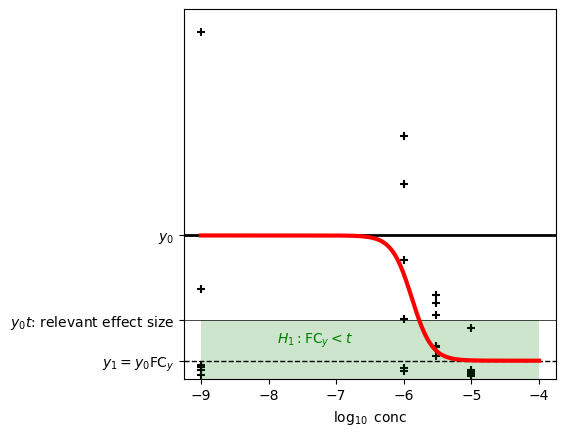

In [16]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax = plot_data(ax, data=data_reshaped)
ax = plot_sampled_curves_sigmoid_1(ax, example_idata['sigmoid 2'].posterior, plot_sampled_curves=False, draw_y0_y1=True)
ax.set_ylim(0, 55)
ax.set_ylabel('')
attila_utils.savefig(fig, 'sigmoid-2-draw_y0_y1')

['named-figure/data-TI26-TNF.png', 'named-figure/data-TI26-TNF.pdf']

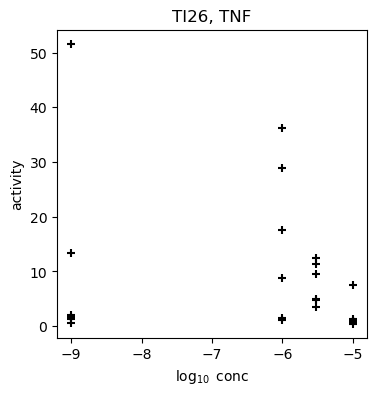

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = plot_data(ax, data=data_reshaped)
ax.set_title('TI26, TNF')
attila_utils.savefig(fig, 'data-TI26-TNF')

['named-figure/forest-plot-sigmoid-4.png',
 'named-figure/forest-plot-sigmoid-4.pdf']

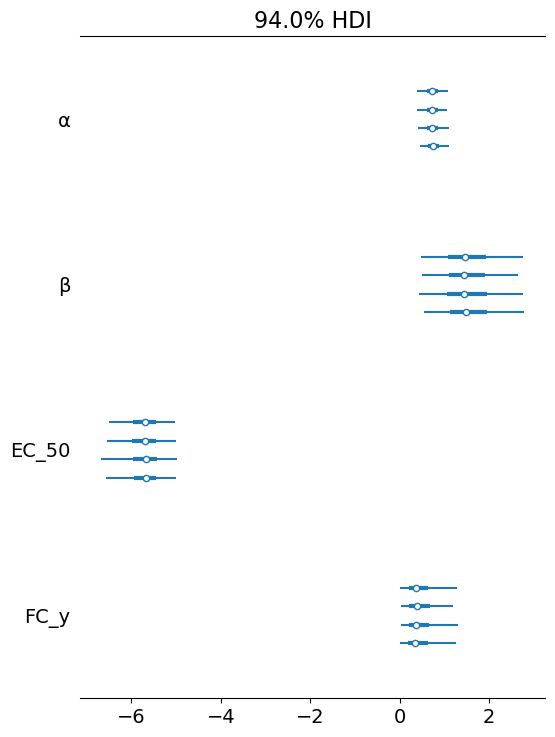

In [18]:
var_names = ['α', 'β', 'EC_50', 'FC_y']
ax = az.plot_forest(example_idata['sigmoid 4'], var_names=var_names)
fig = ax.ravel()[0].figure
attila_utils.savefig(fig, 'forest-plot-sigmoid-4')

In [19]:
az.summary(example_idata['sigmoid 4'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
EC_50,-5.715,0.420,-6.566,-4.990,0.008,0.006,2592.0,2100.0,1.0
y_0,25.169,4.910,15.899,34.198,0.109,0.077,2031.0,1933.0,1.0
FC_y,0.499,0.445,0.008,1.251,0.010,0.007,1702.0,1984.0,1.0
k,11.059,86.184,0.001,21.363,2.297,1.625,2163.0,1519.0,1.0
α,0.750,0.188,0.409,1.092,0.005,0.003,1751.0,2136.0,1.0
β,1.579,0.695,0.508,2.781,0.016,0.011,2029.0,2167.0,1.0
y_1,12.569,11.631,0.089,31.815,0.271,0.192,1669.0,1814.0,1.0
μ[0],14.552,9.354,1.293,29.930,0.225,0.159,1645.0,2271.0,1.0
μ[1],17.986,7.988,5.754,31.602,0.181,0.128,1931.0,2349.0,1.0
μ[2],21.671,6.779,10.631,33.275,0.148,0.104,2180.0,2295.0,1.0


<AxesSubplot: xlabel='y / y'>

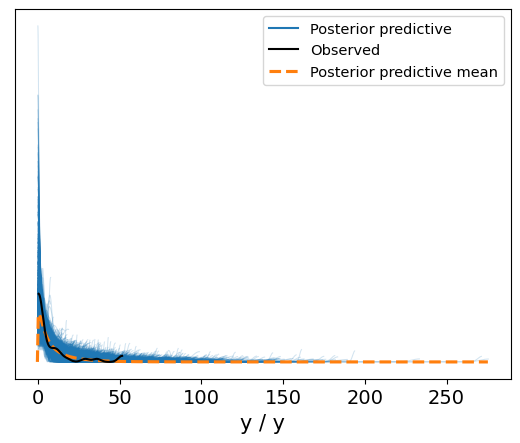

In [20]:
az.plot_ppc(posterior_samples['sigmoid 4'])

In [21]:
model = 'sigmoid 2'
d = pd.DataFrame(posterior_samples[model].posterior_predictive['y'][0], columns=data_reshaped.conc_log10).unstack().to_frame('y')
d['conc_lg'] = d.index.get_level_values(0)
d

y  conc_lg
conc_log10                        
-5.0       0     2.356062     -5.0
           1     2.255406     -5.0
           2     5.931943     -5.0
           3     5.393580     -5.0
           4     6.188994     -5.0
...                   ...      ...
-9.0       995  62.667186     -9.0
           996  52.806912     -9.0
           997  35.409767     -9.0
           998  46.772443     -9.0
           999  64.188057     -9.0

[24000 rows x 2 columns]

['named-figure/posterior-predictive-sigmoid.png',
 'named-figure/posterior-predictive-sigmoid.pdf']

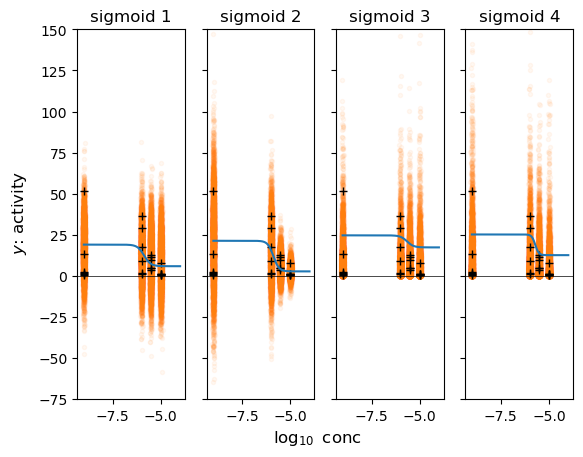

In [22]:
sigmoid_models = [s for s in example_idata.keys() if re.match('^sigmoid.*', s)]
fig, ax = plt.subplots(1, len(sigmoid_models), sharey=True)
for axi, model in zip(ax, sigmoid_models):
    ayy = posterior_samples[model].posterior_predictive['y'][0].transpose().to_numpy()
    axx = data_reshaped.conc_log10.to_numpy().repeat(ayy.shape[1])
    axx += 0.025 * scipy.stats.norm.rvs(size=len(axx))
    ayy = ayy.flatten()
    _ = axi.plot(axx, ayy, linewidth=0, marker='.', color='C1', alpha=0.05)
    _ = axi.plot(data_reshaped.conc_log10, posterior_samples[model].observed_data['y'], linewidth=0, marker='+', color='k', alpha=1)
    means = {k: v['data'] for k, v in example_idata[model].posterior.mean().to_dict()['data_vars'].items()}
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    μ_mean = means['y_1'] + (means['y_0'] - means['y_1']) / (1 + np.exp(means['k'] * (xx - means['EC_50'])))
    axi.plot(xx, μ_mean)
    axi.axhline(0, color='k', linewidth=0.5)
    axi.set_title(model)
    axi.set_ylim(-75, 150)
fig.supxlabel('$\log_{10}$ conc')
fig.supylabel('$y$: activity')
attila_utils.savefig(fig, 'posterior-predictive-sigmoid')

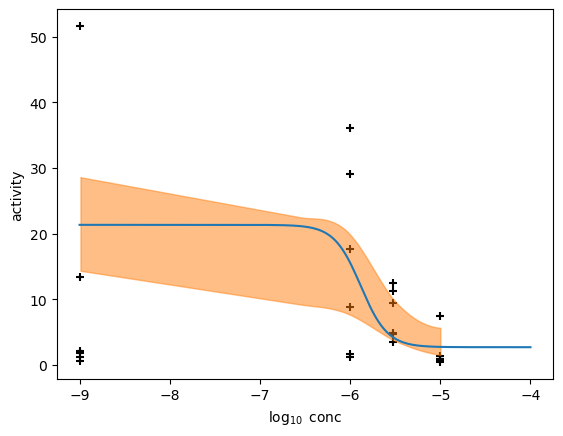

In [23]:
model = 'sigmoid 2'
fig, ax = plt.subplots()
ax = plot_data(ax)
xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
az.plot_hdi(data_reshaped.conc_log10, example_idata[model].posterior['μ'], ax=ax)
means = {k: v['data'] for k, v in example_idata[model].posterior.mean().to_dict()['data_vars'].items()}
μ_mean = means['y_1'] + (means['y_0'] - means['y_1']) / (1 + np.exp(means['k'] * (xx - means['EC_50'])))
ax.plot(xx, μ_mean)

['named-figure/prior-posterior-curves-linear-1.png',
 'named-figure/prior-posterior-curves-linear-1.pdf']

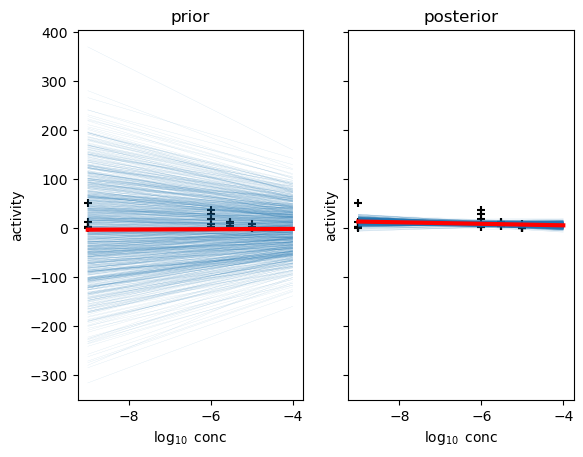

In [24]:
def prior_posterior_curves_linear_1(idata=example_idata):
    fig, ax = plt.subplots(1, 2, sharey=True)
    for axi, idat, prior_posterior in zip(ax, [prior_samples['linear 1'].prior, idata['linear 1'].posterior], ['prior', 'posterior']):
        axi = plot_data(axi)
        axi = plot_sampled_curves_linear_1(ax=axi, data=idat, alpha=0.2)
        axi.set_title(prior_posterior)
    return((fig, ax))

fig, ax = prior_posterior_curves_linear_1()
attila_utils.savefig(fig, 'prior-posterior-curves-linear-1')

['named-figure/prior-posterior-curves-linear-1-zoom.png',
 'named-figure/prior-posterior-curves-linear-1-zoom.pdf']

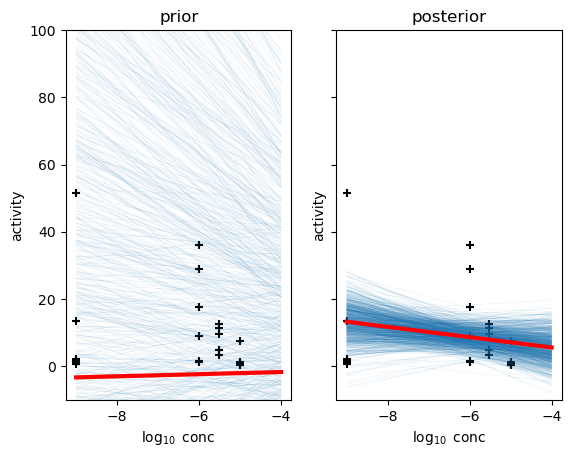

In [25]:
fig, ax = prior_posterior_curves_linear_1()
ax[1].set_ylim(-10, 100)
attila_utils.savefig(fig, 'prior-posterior-curves-linear-1-zoom')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/1162241243.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/1162241243.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/1162241243.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/1162241243.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


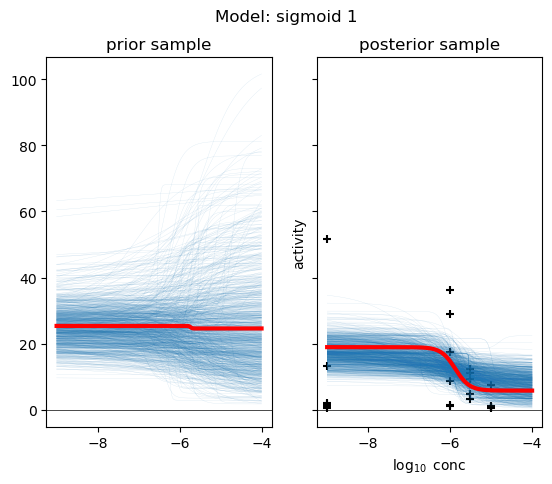

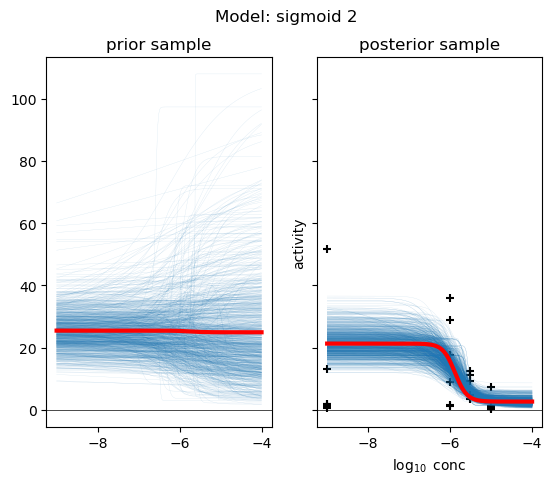

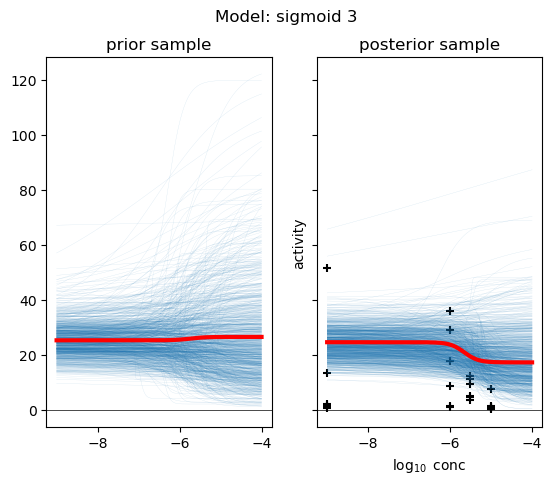

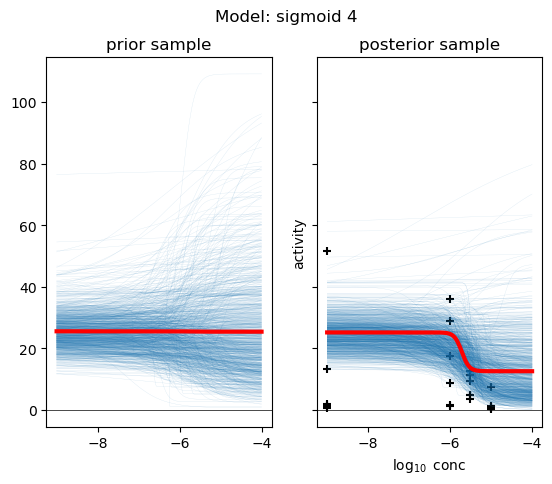

In [26]:
def prior_posterior_curves_sigmoid(model='sigmoid 1', prior_samples=prior_samples, idata=example_idata):
    prior = prior_samples[model].prior
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Model: ' + model)
    for axi, data, title in zip(ax, [prior, idata[model].posterior], ['prior sample', 'posterior sample']):
        if title == 'posterior sample':
            axi = plot_data(axi)
        axi = plot_sampled_curves_sigmoid_1(ax=axi, idata=data, alpha=0.2)
        axi.set_title(title)
        axi.axhline(0, color='k', linewidth=0.5)
    return((fig, ax))

for i, model in zip(range(len(sigmoid_models)), sigmoid_models):
    fig, ax = prior_posterior_curves_sigmoid(model=model, prior_samples=prior_samples)
    attila_utils.savefig(fig, 'prior-posterior-curves-sigmoid-' + str(i + 1))

['named-figure/mcmc-trace-sigmoid-4.png',
 'named-figure/mcmc-trace-sigmoid-4.pdf']

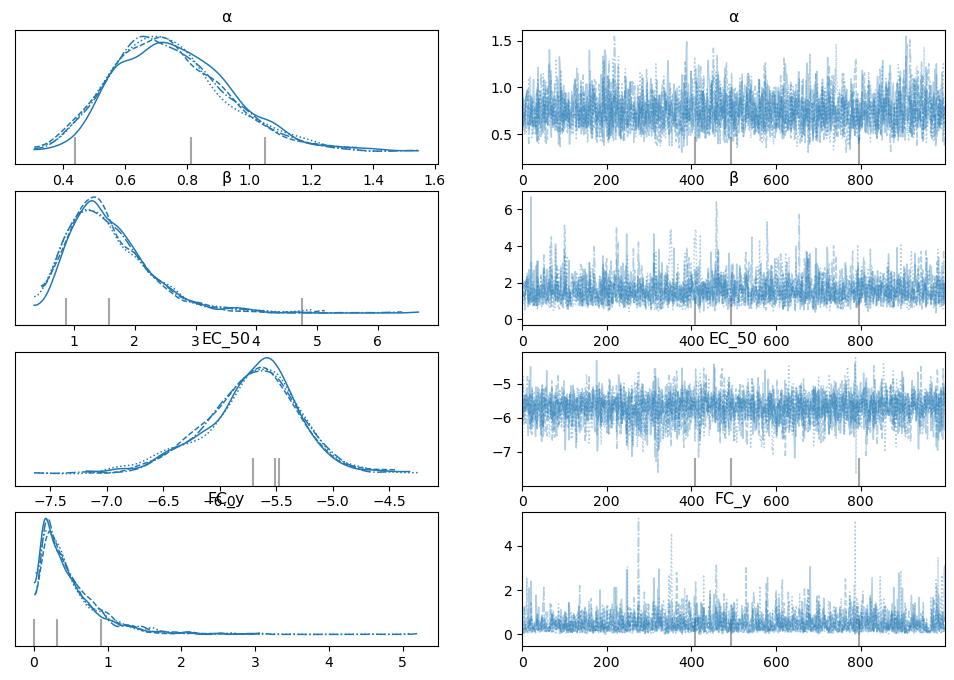

In [27]:
def my_plot_trace(sel_mod='sigmoid 4', var_names=['α', 'β', 'EC_50', 'FC_y'], idata=example_idata):
    ax = az.plot_trace(idata[sel_mod], var_names=var_names)
    fig = ax.ravel()[0].figure
    #fig.suptitle(sel_mod)
    return((fig, ax))

sel_mod = 'sigmoid 4'
fig, ax = my_plot_trace(sel_mod=sel_mod, var_names=['α', 'β', 'EC_50', 'FC_y'])
attila_utils.savefig(fig, 'mcmc-trace-' + sel_mod.replace(' ', '-'))

['named-figure/mcmc-trace-sigmoid-2.png',
 'named-figure/mcmc-trace-sigmoid-2.pdf']

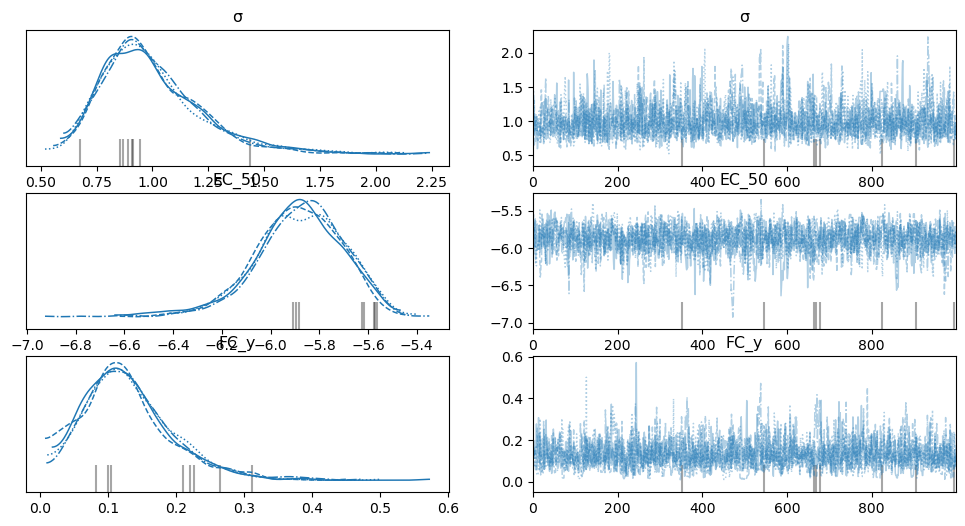

In [28]:
sel_mod = 'sigmoid 2'
fig, ax = my_plot_trace(sel_mod=sel_mod, var_names=['σ', 'EC_50', 'FC_y'])
attila_utils.savefig(fig, 'mcmc-trace-' + sel_mod.replace(' ', '-'))

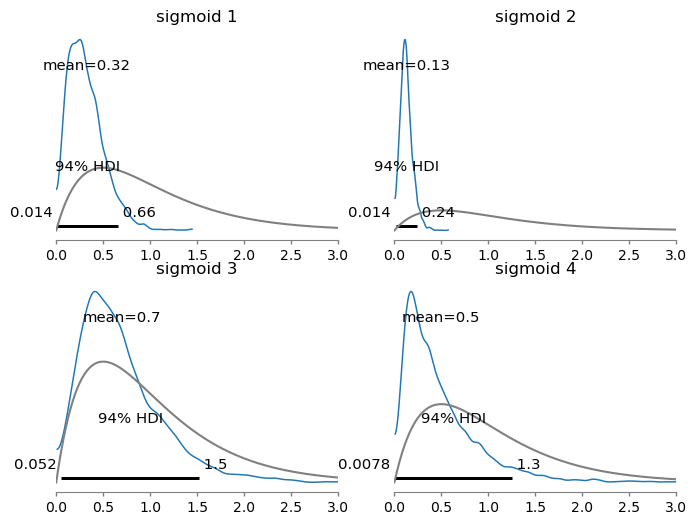

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
for axi, model in zip(ax.ravel(), sigmoid_models):
    az.plot_posterior(example_idata[model], var_names = ['FC_y'], ax=axi, textsize=10)
    xx = np.linspace(0, 5, num=200)
    yy = scipy.stats.gamma.pdf(xx, 2, scale=1/2)
    axi.plot(xx, yy, color='gray')
    axi.set_title(model)
    axi.set_xlim(0, 3)

In [30]:
def get_H1_prob(posterior_idata=example_idata['sigmoid 4'].posterior['FC_y'], t_0=0.5, t_1=None):
    left_tail_prob = sum(sum(posterior_idata < t_0)) if t_0 is not None else 0
    right_tail_prob = sum(sum(posterior_idata > t_1)) if t_1 is not None else 0
    H1_prob = np.float64(left_tail_prob + right_tail_prob)
    H1_prob /= len(posterior_idata.to_numpy().ravel())
    return(H1_prob)



/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/2218844000.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/2218844000.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-sigmoid-2.png',
 'named-figure/prior-posterior-density-sigmoid-2.pdf']

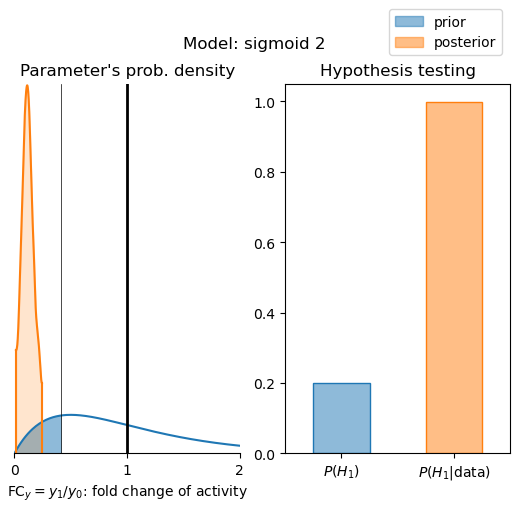

In [31]:
def prior_posterior_density_plot(ax, model='sigmoid 4', x_max=3, t_0=0.5, t_1=None, idata=example_idata):
    alpha = 0.5
    xx = np.linspace(0, x_max, num=200)
    yy_prior = scipy.stats.gamma.pdf(xx, 2, scale=1/2)
    ax.plot(xx, yy_prior, label='prior')
    ax.fill_between(xx, yy_prior, alpha=alpha)
    az.plot_density(idata[model], group='posterior', var_names=['FC_y'], ax=ax, colors='C1', shade=0.2, point_estimate=None)
    where = np.repeat(True, len(xx))
    if t_0 is not None:
        where = where & (xx > t_0)
        ax.axvline(t_0, linewidth=0.5, color='k')
    if t_1 is not None:
        where = where & (xx < t_1)
        ax.axvline(t_1, linewidth=0.5, color='k')
    ax.fill_between(xx, 2, where=where, color='w')
    ax.axvline(1, linewidth=2, color='k', linestyle='solid')
    t = np.repeat(1e3, len(xx))
    ax.set_title('')
    ax.set_xlim(0, x_max)
    ax.set_xlabel('$\mathrm{FC}_y = y_1 / y_0$: fold change of activity')
    ax.margins(y=0)
    return(ax)

def prior_posterior_density_plot_complex(model='sigmoid 4', idata=example_idata):
    alpha = 0.5
    fig, ax = plt.subplots(1, 2)
    t_0 = scipy.stats.gamma.ppf(0.2, 2, scale=1/2)
    t_1 = None
    ax[0] = prior_posterior_density_plot(ax[0], model=model, x_max=2, t_0=t_0, t_1=t_1)
    d = {'prior': scipy.stats.gamma.cdf(t_0, 2, scale=1/2),
         'posterior': cba.get_H1_posterior_prob(posterior_idata=idata[model].posterior['FC_y'],
                                               H1_prior_prob=0.2, H1_increase=False)}
    pd.Series(d).plot(kind='bar', ax=ax[1], color=['C0', 'C1'], alpha=alpha)
    pd.Series(d).plot(kind='bar', ax=ax[1], edgecolor=['C0', 'C1'], fill=False, linewidth=1)
    ax[1].set_xticklabels(['$P(H_1)$', '$P(H_1|\mathrm{data})$'], rotation=0)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
    ax[0].set_title('Parameter\'s prob. density')
    ax[1].set_title('Hypothesis testing')
    handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]
    fig.legend(handles=handles, labels=d.keys(), loc='upper left', bbox_to_anchor=(0.7, 1.05))
    fig.suptitle('Model: ' + model)
    return((fig, ax))

model = 'sigmoid 2'
fig, ax = prior_posterior_density_plot_complex(model=model)
ax[0].set_ylim(0, 7.05)
ax[1].set_ylim(0, 1.05)
attila_utils.savefig(fig, 'prior-posterior-density-' + model.replace(' ', '-'))

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/2218844000.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/2218844000.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-sigmoid-4.png',
 'named-figure/prior-posterior-density-sigmoid-4.pdf']

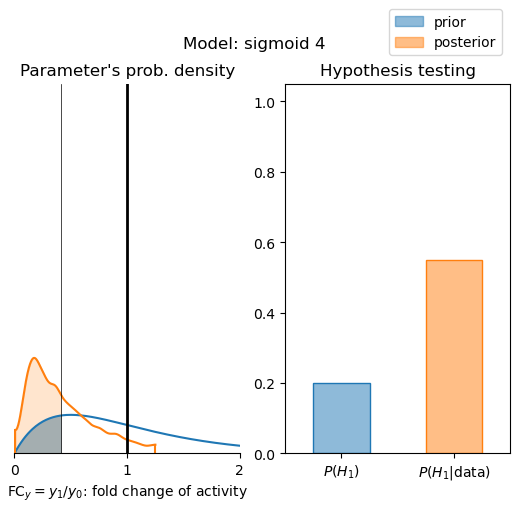

In [32]:
model = 'sigmoid 4'
fig, ax = prior_posterior_density_plot_complex(model=model)
ax[0].set_ylim(0, 7.05)
ax[1].set_ylim(0, 1.05)
attila_utils.savefig(fig, 'prior-posterior-density-' + model.replace(' ', '-'))

In [33]:
drug_concentrations_LPS = {
    'TI1': {
        'c1': 100e-6,
        'c2': 10e-6,
        'c3': 1e-6,
        'LC': 1e-9,
    },
    'TI21': {
        'c1': 100e-6,
        'c2': 10e-6,
        'c3': 1e-6,
        'LC': 1e-9,
    },
    'TI26': {
        'c1': 10e-6,
        'c2': 3e-6,
        'c3': 1e-6,
        'LC': 1e-9,
    },
}
assays_LPS = ['IL-1b', 'IL-6', 'IL-8', 'MTT', 'TNF']
H1_increase_LPS = False
bname_LPS = '../../resources/cell-based-assays/Tina-email-2023-08-31/'

drug_concentrations_Ab = {
    'TI1': {
        'c1': 100e-6,
        'c2': 10e-6,
        'c3': 1e-6,
        'VC': 1e-9,
    },
    'TI21': {
        'c1': 100e-6,
        'c2': 10e-6,
        'c3': 1e-6,
        'VC': 1e-9,
    },
    'TI26': {
        'c1': 10e-6,
        'c2': 3e-6,
        'c3': 1e-6,
        'VC': 1e-9,
    },
}
assays_Ab = ['pHrodo-number-4h', 'supernatant']
H1_increase_Ab = [True, False]
bname_Ab = '../../resources/cell-based-assays/Tina-email-2023-08-29/'

'''
def get_experiment_conditions(exp_name, assays, drug_concentrations, H1_increase=True, bname=bname_LPS):
    d = {(exp_name, a, d): c for d, c in drug_concentrations.items() for a in assays}
    #return(d)
    experiments = pd.Series(d.values(), index=d.keys()).to_frame('concentrations')
    experiments['compound'] = experiments.index.get_level_values(2)
    experiments['assay'] = experiments.index.get_level_values(1)
    if isinstance(H1_increase, bool):
        experiments['H1_increase'] = H1_increase
    else:
        d = dict(zip(assays, H1_increase))
        experiments['H1_increase'] = [d[e] for e in experiments.index.get_level_values(level=1)]
    experiments['bname'] = bname
    experiments = experiments.sort_index(axis=0, level=1)
    return(experiments)
'''

experiments_LPS = cba.get_experiment_conditions('LPS neuroinflammation, iPSC', assays_LPS, drug_concentrations_LPS, H1_increase=False, bname=bname_LPS)
experiments_Ab = cba.get_experiment_conditions('Abeta clearance, iPSC', assays_Ab, drug_concentrations_Ab, H1_increase=H1_increase_Ab, bname=bname_Ab)
experiments = pd.concat([experiments_Ab, experiments_LPS], axis=0)
experiments

concentrations  \
Abeta clearance, iPSC       pHrodo-number-4h TI1   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'VC':...   
                                             TI21  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'VC':...   
                                             TI26  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'VC': ...   
                            supernatant      TI1   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'VC':...   
                                             TI21  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'VC':...   
                                             TI26  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'VC': ...   
LPS neuroinflammation, iPSC IL-1b            TI1   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI21  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI26  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...   
                            IL-6             TI1   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI21  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI26  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...   
                            IL-8             TI1   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI21  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI26  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...   
                            MTT              TI1   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI21  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI26  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...   
                            TNF              TI1   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI21  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...   
                                             TI26  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...   

                                                  compound             assay  \
Abeta clearance, iPSC       pHrodo-number-4h TI1       TI1  pHrodo-number-4h   
                                             TI21     TI21  pHrodo-number-4h   
                                             TI26     TI26  pHrodo-number-4h   
                            supernatant      TI1       TI1       supernatant   
                                             TI21     TI21       supernatant   
                                             TI26     TI26       supernatant   
LPS neuroinflammation, iPSC IL-1b            TI1       TI1             IL-1b   
                                             TI21     TI21             IL-1b   
                                             TI26     TI26             IL-1b   
                            IL-6             TI1       TI1              IL-6   
                                             TI21     TI21              IL-6   
                                             TI26     TI26              IL-6   
                            IL-8             TI1       TI1              IL-8   
                                             TI21     TI21              IL-8   
                                             TI26     TI26              IL-8   
                            MTT              TI1       TI1               MTT   
                                             TI21     TI21               MTT   
                                             TI26     TI26               MTT   
                            TNF              TI1       TI1               TNF   
                                             TI21     TI21               TNF   
                                             TI26     TI26               TNF   

                                    

In [34]:
e = 'LPS neuroinflammation, iPSC'
E = experiments_LPS.loc[[(e, 'IL-6', 'TI1'), (e, 'IL-6', 'TI26'), (e, 'IL-1b', 'TI26')]]

e1 = 'Abeta clearance, iPSC'
e2 = 'LPS neuroinflammation, iPSC'
E = experiments.loc[[(e1, 'pHrodo-number-4h', 'TI1'), (e1, 'pHrodo-number-4h', 'TI26'), (e2, 'IL-1b', 'TI26')]]

In [35]:
test_idata = cba.fit_models(models=['sigmoid 2', 'sigmoid 4'], experiments=E)
test_idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-A

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


sigmoid 2  \
                                                                                      model   
Abeta clearance, iPSC       pHrodo-number-4h TI1   <pymc.model.Model object at 0x168d814d0>   
                                             TI26  <pymc.model.Model object at 0x168f5c8d0>   
LPS neuroinflammation, iPSC IL-1b            TI26  <pymc.model.Model object at 0x168f8a490>   

                                                                                                      \
                                                                                               idata   
Abeta clearance, iPSC       pHrodo-number-4h TI1   (posterior, log_likelihood, sample_stats, obse...   
                                             TI26  (posterior, log_likelihood, sample_stats, obse...   
LPS neuroinflammation, iPSC IL-1b            TI26  (posterior, log_likelihood, sample_stats, obse...   

                                                                                  sigmoid 4  \
                                                                                      model   
Abeta clearance, iPSC       pHrodo-number-4h TI1   <pymc.model.Model object at 0x15f5ea750>   
                                             TI26  <pymc.model.Model object at 0x163a21390>   
LPS neuroinflammation, iPSC IL-1b            TI26  <pymc.model.Model object at 0x161b81390>   

                                                                                                      
                                                                                               idata  
Abeta clearance, iPSC       pHrodo-number-4h TI1   (posterior, log_likelihood, sample_stats, obse...  
                                             TI26  (posterior, log_likelihood, sample_stats, obse...  
LPS neuroinflammation, iPSC IL-1b            TI26  (posterior, log_likelihood, sample_stats, obse...

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/1162241243.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_47368/1162241243.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


['named-figure/posterior-curves-P-H1-sigmoid-2-vs-sigmoid-4.png',
 'named-figure/posterior-curves-P-H1-sigmoid-2-vs-sigmoid-4.pdf']

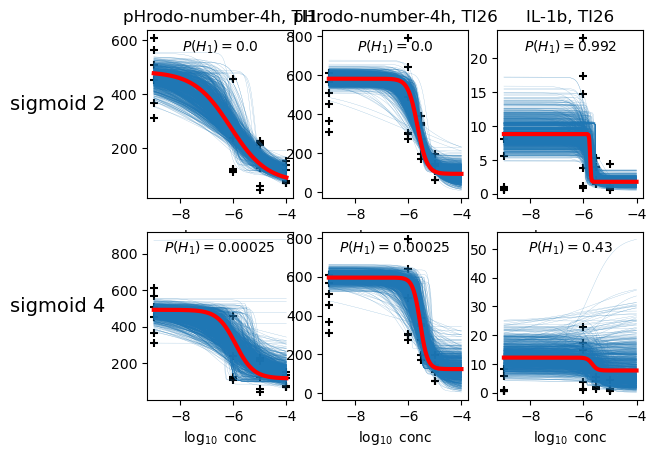

In [36]:
def plot_data_posterior_curves(ax, exper, assay='IL-1b', compound='TI26', model='sigmoid 2', idata=test_idata, experiments=experiments):
    concentrations, bname = experiments.loc[(exper, assay, compound), ['concentrations', 'bname']]
    data_reshaped = cba.read_reshape_data(compound=compound, assay=assay, concentrations=concentrations, bname=bname)
    ax = plot_sampled_curves_sigmoid_1(ax, idata=idata.loc[(exper, assay, compound), (model, 'idata')].posterior)
    ax = plot_data(ax, data=data_reshaped)
    return(ax)

fig, ax = plt.subplots(2, test_idata.shape[0])
for axi, ix in zip(ax.transpose(), test_idata.index):
    exper, assay, compound = ix
    for axii, model in zip(axi, test_idata.xs('model', axis=1, level=1).columns):
        plot_data_posterior_curves(axii, exper=exper, assay=assay, compound=compound, model=model, idata=test_idata, experiments=experiments)
        axii.set_ylabel('')
        H1_prob = cba.get_H1_posterior_prob(test_idata.loc[ix, (model, 'idata')].posterior['FC_y'],
                                           H1_increase=E.loc[ix, 'H1_increase'])
        axii.text(0.5, 0.9, '$P(H_1) = {}$'.format(H1_prob), horizontalalignment='center', verticalalignment='center', transform=axii.transAxes)

[axi.set_title(ix[1] + ', ' + ix[2]) for axi, ix in zip(ax[0, :], test_idata.index)]
[axi.set_ylabel(m, rotation=0, fontsize=14, horizontalalignment='right') for axi, m in zip(ax[:, 0], test_idata.xs('model', axis=1, level=1).columns)]
attila_utils.savefig(fig, 'posterior-curves-P-H1-sigmoid-2-vs-sigmoid-4')

In [37]:
P_H1_test = cba.get_H1_posterior_prob_batch(test_idata.xs('idata', axis=1, level=1)['sigmoid 2'], E.H1_increase, 0.2)
P_H1_test

Abeta clearance, iPSC        pHrodo-number-4h  TI1     0.000
                                               TI26    0.000
LPS neuroinflammation, iPSC  IL-1b             TI26    0.992
dtype: float64

['named-figure/P_H1_test-barchart.png', 'named-figure/P_H1_test-barchart.pdf']

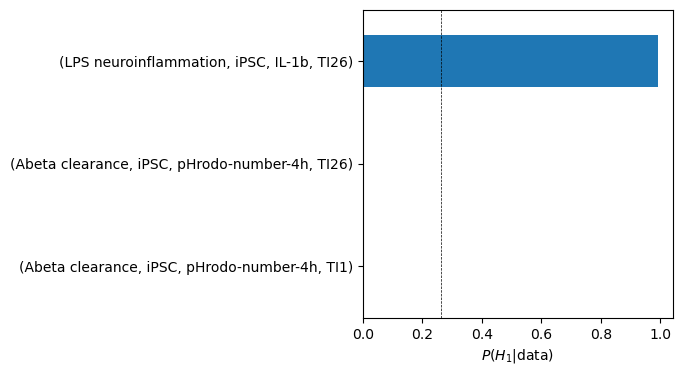

In [38]:
fig, ax = plt.subplots(figsize=(4, 4))
P_H1_test.plot(kind='barh', ax=ax)
P_H1_prior = scipy.stats.gamma.cdf(0.5, 2, scale=1/2)
ax.axvline(P_H1_prior, color='k', linewidth=0.5, linestyle='dashed')
ax.set_xlabel('$P(H_1|\mathrm{data})$')
attila_utils.savefig(fig, 'P_H1_test-barchart')

In [39]:
idata = cba.fit_models(models=['sigmoid 2'], experiments=experiments)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-A

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-A

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-A

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [40]:
s = idata.xs('idata', axis=1, level=1)['sigmoid 2']
P_H1 = cba.get_H1_posterior_prob_batch(idata.xs('idata', axis=1, level=1)['sigmoid 2'], experiments.H1_increase, 0.2)
sel_cols = ['assay', 'compound', 'concentrations', 'bname']
scorr = pd.concat([experiments[sel_cols].apply(lambda r: spearmanr(cba.read_reshape_data(**r.to_dict()).drop([k for k in r.loc['concentrations'].keys() if not re.match('^c[0-9]', k)][0], axis=0, level=1).drop('conc', axis=1))[ix], axis=1).to_frame(colname) for ix, colname in zip(range(2), ['coef', 'pval'])], axis=1)
results = pd.concat([scorr, P_H1.to_frame('P(H_1)')], axis=1)
results['-log p'] = results.pval.apply(lambda p: -np.log10(p))
results

coef      pval  \
Abeta clearance, iPSC       pHrodo-number-4h TI1  -0.393445  0.106237   
                                             TI21 -0.419674  0.082954   
                                             TI26 -0.793857  0.000084   
                            supernatant      TI1   0.301641  0.223808   
                                             TI21  0.157378  0.532845   
                                             TI26  0.104919  0.678638   
LPS neuroinflammation, iPSC IL-1b            TI1   0.445904  0.063639   
                                             TI21 -0.407959  0.104040   
                                             TI26 -0.524593  0.025411   
                            IL-6             TI1   0.000000  1.000000   
                                             TI21 -0.790453  0.000268   
                                             TI26 -0.563937  0.014784   
                            IL-8             TI1   0.183608  0.465823   
                                             TI21 -0.374179  0.138969   
                                             TI26 -0.367215  0.133857   
                            MTT              TI1  -0.867371  0.000003   
                                             TI21 -0.118094  0.640714   
                                             TI26 -0.203385  0.418254   
                            TNF              TI1   0.249182  0.318698   
                                             TI21 -0.682097  0.002559   
                                             TI26 -0.629512  0.005120   

                                                    P(H_1)    -log p  
Abeta clearance, iPSC       pHrodo-number-4h TI1   0.00000  0.973725  
                                             TI21  0.00000  1.081165  
                                             TI26  0.00000  4.076240  
                            supernatant      TI1   0.00850  0.650125  
                                             TI21  0.00025  0.273399  
                                             TI26  0.00425  0.168362  
LPS neuroinflammation, iPSC IL-1b            TI1   0.23950  1.196274  
                                             TI21  0.96525  0.982799  
                                             TI26  0.99200  1.594980  
                            IL-6             TI1   0.70825 -0.000000  
                                             TI21  1.00000  3.572167  
                                             TI26  1.00000  1.830197  
                            IL-8             TI1   0.95425  0.331779  
                                             TI21  1.00000  0.857082  
                                             TI26  1.00000  0.873359  
                            MTT              TI1   1.00000  5.501786  
                                             TI21  0.00025  0.193336  
                                             TI26  0.00000  0.378560  
                            TNF              TI1   0.75825  0.496620  
                                             TI21  1.00000  2.591972  
                                             TI26  0.99875  2.290771

['named-figure/posterior_PH1_vs_spearman_rank.png',
 'named-figure/posterior_PH1_vs_spearman_rank.pdf']

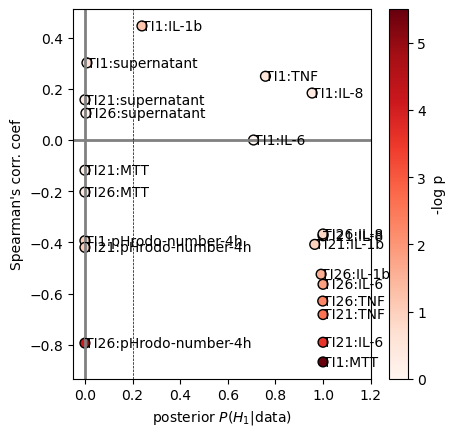

In [41]:
P_H1_prior = 0.2
fig, ax = plt.subplots(figsize=(4.8, 4.8))
linewidth = 2
color = 'gray'
ax.axvline(0, linewidth=linewidth, color=color)
ax.axhline(0, linewidth=linewidth, color=color)
results.plot(kind='scatter', y='coef', x='P(H_1)', c='-log p', ax=ax, s=50, cmap='Reds', edgecolors='k')
ax.axvline(P_H1_prior, color='k', linewidth=0.5, linestyle='dashed', label='prior $P(H_1)$')
ax.set_xlabel('posterior $P(H_1|\mathrm{data})$')
ax.set_ylabel('Spearman\'s corr. coef')
ax.set_xlim(ax.get_xlim()[0], 1.2)
for ix in results.index:
    _, assay, compound = ix
    y = results.loc[ix, 'coef']
    x = results.loc[ix, 'P(H_1)']
    ax.text(x=x, y=y, s=compound + ':' + assay, rotation=0, horizontalalignment='left', verticalalignment='center')
attila_utils.savefig(fig, 'posterior_PH1_vs_spearman_rank')

['named-figure/P_H1-barchart.png', 'named-figure/P_H1-barchart.pdf']

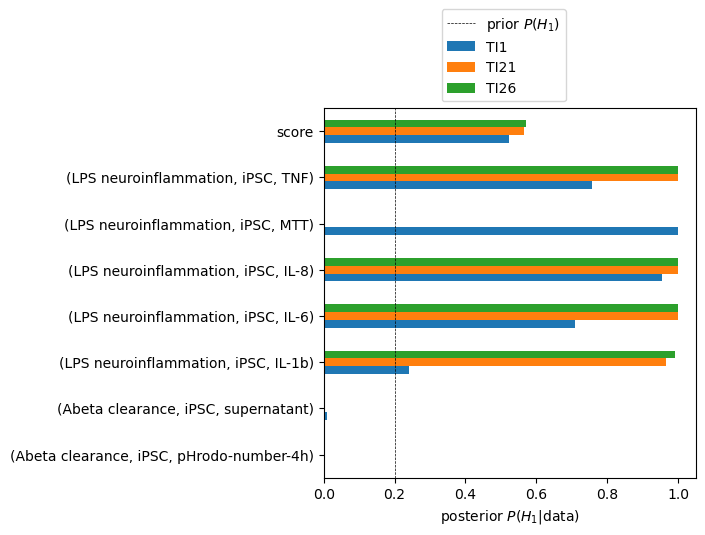

In [42]:
s = P_H1
fig, ax = plt.subplots(figsize=(4.8, 4.8))
res = s.unstack()#.xs('LPS neuroinflammation, iPSC', axis=0, level=0)
res = pd.concat([res, res.mean(axis=0).to_frame('score').transpose()], axis=0)
res.plot(kind='barh', ax=ax, legend=None)
ax.axvline(P_H1_prior, color='k', linewidth=0.5, linestyle='dashed', label='prior $P(H_1)$')
ax.set_xlabel('posterior $P(H_1|\mathrm{data})$')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1))
attila_utils.savefig(fig, 'P_H1-barchart')

['named-figure/P_H1-heatmap.png', 'named-figure/P_H1-heatmap.pdf']

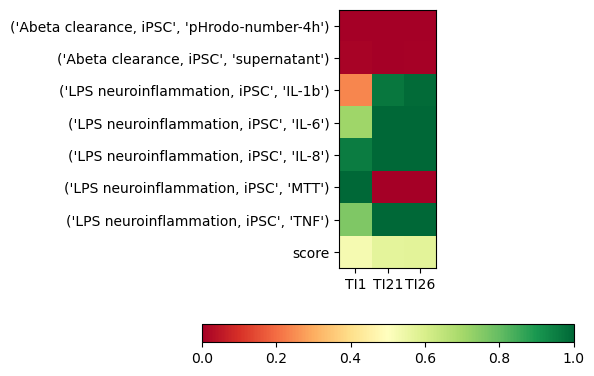

In [43]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
fontsize = 10
im = ax.imshow(X=res, cmap='RdYlGn')
cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal')
ax.set_yticks(range(res.shape[0]))
ax.set_yticklabels(res.index, rotation=0, fontsize=fontsize)
ax.set_xticks(range(res.shape[1]))
ax.set_xticklabels(res.columns, rotation=0, fontsize=fontsize)
attila_utils.savefig(fig, 'P_H1-heatmap')

['named-figure/data-posterior-curve-TI26-MTT.png',
 'named-figure/data-posterior-curve-TI26-MTT.pdf']

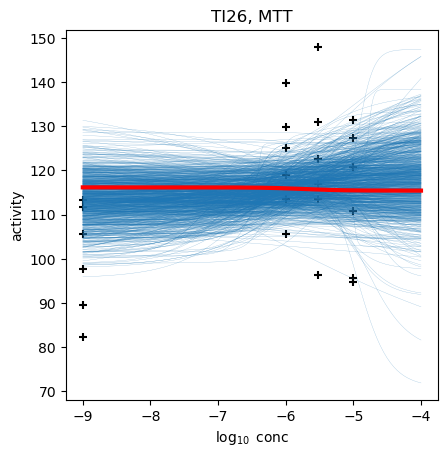

In [44]:
def posterior_sample_plotter(exper, compound='TI26', assay='MTT', experiments=experiments):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    concentrations = experiments.loc[(exper, assay, compound), 'concentrations']
    data_reshaped = cba.read_reshape_data(compound=compound, assay=assay, concentrations=concentrations)
    ax = plot_data(ax, data_reshaped)
    ax = plot_sampled_curves_sigmoid_1(ax, idata.loc[(exper, assay, compound), ('sigmoid 2', 'idata')].posterior, data_reshaped=data_reshaped)
    ax.set_title(compound + ', ' + assay)
    return(fig, ax)

exper = 'LPS neuroinflammation, iPSC'
compound='TI26'; assay='MTT'
fig, ax = posterior_sample_plotter(exper=exper, compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

['named-figure/data-posterior-curve-TI21-MTT.png',
 'named-figure/data-posterior-curve-TI21-MTT.pdf']

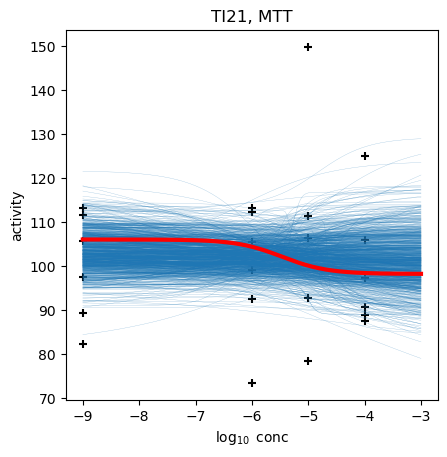

In [45]:
compound='TI21'; assay='MTT'
fig, ax = posterior_sample_plotter(exper=exper, compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

['named-figure/data-posterior-curve-TI21-IL-1b.png',
 'named-figure/data-posterior-curve-TI21-IL-1b.pdf']

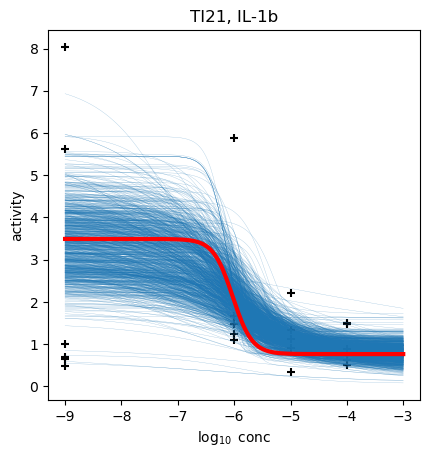

In [46]:
compound='TI21'; assay='IL-1b'
fig, ax = posterior_sample_plotter(exper=exper, compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

['named-figure/data-posterior-curve-TI21-TNF.png',
 'named-figure/data-posterior-curve-TI21-TNF.pdf']

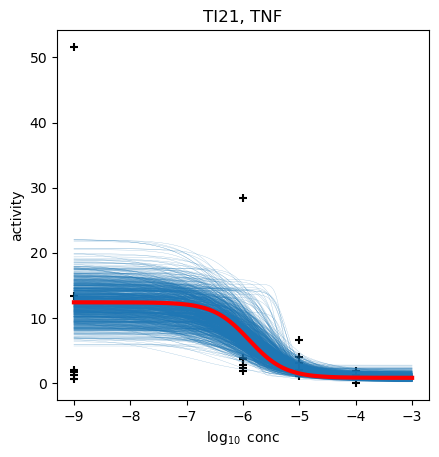

In [47]:
compound='TI21'; assay='TNF'
fig, ax = posterior_sample_plotter(exper=exper, compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

In [48]:
%connect_info

{
  "shell_port": 49298,
  "iopub_port": 49299,
  "stdin_port": 49300,
  "control_port": 49302,
  "hb_port": 49301,
  "ip": "127.0.0.1",
  "key": "5c113b76-073dafa07a748978a23d456d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f3311e98-2c68-4b2c-bc4f-76118be40d71.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
